## Set to directory with python scripts

In [1]:
scripts_path = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/scripts/'

# Path to save figures
path_to_save = '/'.join(scripts_path.split('/')[:-2]) + '/'

# Path to save supplementary and figure data folders
save_path = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/'
%cd $scripts_path

/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/scripts


## Load modules

In [2]:
import scipy.stats as st
from collections import Counter
import sklearn
from matplotlib import cm
import scipy
import  itertools
from datetime import datetime
from seaborn import clustermap
from scipy.cluster.hierarchy import linkage
from sklearn.linear_model import LogisticRegression
import os
import time
import pickle as pkl
import pandas as pd
from dataLoader import *
from basic_data_methods_helper import *
from skbio.stats.distance import permanova, DistanceMatrix, anosim
from skbio.stats.distance import mantel
from statsmodels.stats.multitest import multipletests
from matplotlib.collections import LineCollection
from Bio import Phylo
import re
from statistics import mode
import seaborn as sns
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
import matplotlib.lines as mlines
import seaborn as sns
from skbio.diversity.alpha import chao1

# Set font for figures
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

## Load data

In [3]:
# set data_path to point to directory with data
data_path = scripts_path + 'inputs/'

# Option to change filtering criteria
dl = dataLoader(path = data_path, pt_perc = {'metabs': .25, '16s': .1, 'scfa': 0, 'toxin':0}, meas_thresh = 
                {'metabs': 0, '16s': 10, 'scfa': 0, 'toxin':0}, 
                var_perc = {'metabs': 50, '16s': 5, 'scfa': 0, 'toxin':0}, pt_tmpts = 1)

No patient demographic/clinical data available due to identifiability


# Figure 5 - summary figure

### Get features to plot in figure from univariate and predictive analysis

In [26]:
univariate = path_to_save + 'univariate_analysis_control/'
predictive = path_to_save + 'predictive_feature_tables/'

interval_num = 75
feats_fig5 = {}
# feats_dict_labels = {}
dtype = 'metabs'
pred_feats = {}
univariate_feats = []
all_metabs = []
underlying_data = {}
for folder in os.listdir(predictive):
    if 'slope' in folder:
        continue
    if dtype not in folder:
        continue
    week = float(folder.split('week')[-1])
    if week not in underlying_data.keys():
        underlying_data[week] = {}
    if week not in feats_fig5.keys():
        feats_fig5[week] = {}
    if folder not in feats_fig5[week].keys():
        feats_fig5[week][folder] = {}
    for file in os.listdir(predictive + folder):
        print(file)
        if file.split('-')[0] not in pred_feats.keys():
            pred_feats[file.split('-')[0]] = []
        sname = file.split('-')[1].split('.')[0]
        score = float(sname[0] + '.' + sname[1:])
        if score < 0.7:
            continue
        coefs = pd.read_csv(predictive + folder + '/' + file, index_col = [0])
        seqs0 = coefs.index.values[coefs.iloc[:,0] != 1]
        seqs = []
        tmp = []
        for seq in seqs0:
            interval = eval(coefs['95% Interval'].loc[seq])
            interval_wide = eval(coefs[str(interval_num) + '% Interval'].loc[seq])
            if seq not in underlying_data[week].keys():
                underlying_data[week][seq] = {}
#             else:
            underlying_data[week][seq][(folder.split('_week')[0], file, 'Median')] = coefs.loc[seq].iloc[0]
            underlying_data[week][seq][(folder.split('_week')[0], file,'95% Interval')] = interval
            underlying_data[week][seq][(folder.split('_week')[0], file,str(interval_num) + '% Interval')] = interval_wide
            if min(interval)>1 or max(interval)<1:
                tmp.append(seq)
            if min(interval_wide)>1 or max(interval_wide)<1:
                seqs.append(seq)
        effect = coefs.loc[seqs].iloc[:,0]
        if 'RF' in file:
            univariate_path = univariate + folder.split('_')[0] + '/OLS_metabs' + str(int(
                float(folder.split('_week')[1]))) + '.csv'
            pvals = pd.read_csv(univariate_path, index_col = [0])
            common_effects = list(set(effect.index.values).intersection(set(pvals.index.values)))
            rownames = effect.loc[common_effects].loc[pvals['coef, outcome'].loc[
                common_effects]< 0].index.values
            effect.loc[rownames] = -effect.loc[rownames]
        feats_fig5[week][folder][file] = effect
        pred_feats[file.split('-')[0]].extend(tmp)
        all_metabs.extend(seqs)
for file in os.listdir(univariate + dtype):
    if '[' in file:
        continue
    if '.csv' not in file or 'ecurrer' in file:
        continue
    if dtype == '16s' and 'deseq2' not in file:
        continue
    pvals = pd.read_csv(univariate + dtype + '/' + file, index_col = [0])
    if 'padj' in pvals.columns.values:
        pa = 'padj'
        ts = 'test statistic'
    else:
        pa = 'FDR, Outcome'
        ts = 'coef, outcome'

    p_imp = pvals.index.values[pvals[pa]<0.1]
    p_effect = pvals.loc[p_imp]
    week = int(file.split('.')[0][-1])
    for feat in p_imp:
        if feat not in underlying_data[week].keys():
            underlying_data[week][feat] = {}
        underlying_data[week][feat][(dtype, 'univariate', 'FDR')] = pvals.loc[feat][pa]
        try:
            underlying_data[week][feat][(dtype, 'univariate', 'Direction')] = pvals.loc[feat]['Direction']
        except:
            underlying_data[week][feat][(dtype, 'univariate', 'Direction')] = np.sign(pvals.loc[feat]['coef, outcome'])
        underlying_data[week][feat][(dtype, 'univariate', 'test statistic')] = pvals.loc[feat][ts]

    if week not in feats_fig5.keys():
        feats_fig5[week] = {}
    if 'univariate' not in feats_fig5[week].keys():
        feats_fig5[week]['univariate'] = {}
    feats_fig5[week]['univariate'][file] = p_effect
    univariate_feats.extend(p_imp)
    all_metabs.extend(p_effect.index.values)

cox2-0705.csv
LR-049.csv
RF-0784.csv
RF-068.csv
LR-0768.csv
cox2-0768.csv
RF-0671.csv
LR-0786.csv
cox2-0785.csv
LR-0513.csv
RF-0774.csv
cox2-078.csv
cox2-0528.csv
RF-0427.csv
LR-0482.csv
cox2-0538.csv
RF-04.csv
LR-0518.csv
cox2-074.csv
LR-0783.csv
RF-0652.csv
LR-037.csv
RF-0786.csv
cox2-0695.csv
cox2-0592.csv
RF-0493.csv
LR-0526.csv


In [7]:
for week in underlying_data.keys():
    val = pd.DataFrame(underlying_data[week]).T
    path_to_save_data= '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Rebuttal 2/GenFigure&AnalysesData/'
    if os.path.isfile(path_to_save_data + '/' + 'Fig_5_data_' + str(interval_num) + 'interval.xlsx'):
        with pd.ExcelWriter(path_to_save_data + '/' + 'Fig_5_data_' + str(interval_num) + 'interval.xlsx', mode='a') as writer:
            val.to_excel(writer, sheet_name='Week' + str(week))
    else:
        with pd.ExcelWriter(path_to_save_data + '/' + 'Fig_5_data_' + str(interval_num) + 'interval.xlsx', mode = 'w') as writer:
            val.to_excel(writer, sheet_name = 'Week' + str(week))

### Plot figure

2.0
ERROR: tetrahydrocortisol glucuronide 
1.0


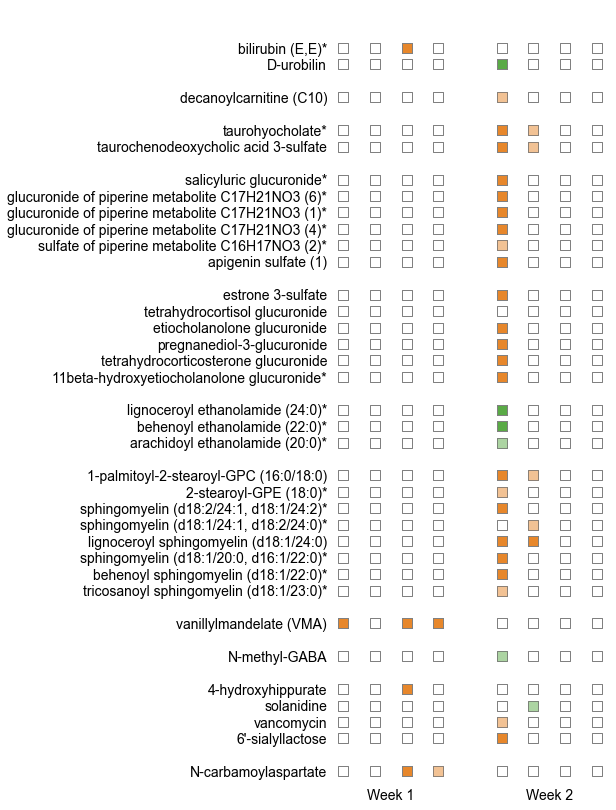

In [31]:
custom_order_w_add_ons = ['bilirubin (E,E)*','D-urobilin','','decanoylcarnitine (C10)','','taurohyocholate*','taurochenodeoxycholate','taurochenodeoxycholic acid 3-sulfate','',
               'salicyluric glucuronide*', 'glucuronide of piperine metabolite C17H21NO3 (6)*','glucuronide of piperine metabolite C17H21NO3 (1)*',
               'glucuronide of piperine metabolite C17H21NO3 (4)*','sulfate of piperine metabolite C16H17NO3 (2)*','apigenin sulfate (1)',
                '',
                '21-hydroxypregnanolone monosulfate (1)','estriol 3-sulfate','estrone 3-sulfate','tetrahydrocortisol glucuronide','cortolone glucuronide (1)', 'etiocholanolone glucuronide',
               'pregnanediol-3-glucuronide','tetrahydrocorticosterone glucuronide',
                          '11beta-hydroxyetiocholanolone glucuronide*','tetrahydrocortisol glucuronide',
                '',
                'lignoceroyl ethanolamide (24:0)*','behenoyl ethanolamide (22:0)*','arachidoyl ethanolamide (20:0)*',
                '',
               '1,2-dipalmitoyl-GPC (16:0/16:0)','2-palmitoyl-GPC* (16:0)*','1-palmitoyl-2-stearoyl-GPC (16:0/18:0)',
                          '2-stearoyl-GPE (18:0)*','1-stearoyl-GPS (18:0)*','sphingomyelin (d18:2/24:1, d18:1/24:2)*',
                          'sphingomyelin (d18:1/24:1, d18:2/24:0)*',
               'lignoceroyl sphingomyelin (d18:1/24:0)', 
                          'sphingomyelin (d18:1/20:0, d16:1/22:0)*','behenoyl sphingomyelin (d18:1/20:0, d16:1/22:0)*',
                          'behenoyl sphingomyelin (d18:1/22:0)*','tricosanoyl sphingomyelin (d18:1/23:0)*',
               '','linolenoyl-linolenoyl-glycerol (18:3/18:3) [2]*','','vanillylmandelate (VMA)','','N-methyl-GABA',
                          '3-hydroxyphenylacetate','','4-hydroxyhippurate','1,1-kestotetraose','N-acetylpyrraline',
                          'digalacturonic acid','solanidine','vancomycin',"6'-sialyllactose",'','N-carbamoylaspartate']
custom_order = np.flipud(custom_order_w_add_ons).tolist()
to_remove = list(set(custom_order) - set(all_metabs))
to_remove.remove('')
for val in to_remove:
    custom_order.remove(val)
    
const = 0
val = 0
for ii,c in enumerate(custom_order):
    if c == '':
        const += 1
    else:
        const = 0
    if const >= 2:
        custom_order.pop(ii - val)
        val += 1

fig, ax = plt.subplots(figsize = (5,(14/44)*len(custom_order)))
# fig.subplots_adjust(top = 10)
ls_plot = np.where(np.array(custom_order) != '')[0]
ax.scatter(np.concatenate([[0]*len(ls_plot),[5]*len(ls_plot)]), 
           list(ls_plot)*2, s = 85, color = 'white',edgecolors = 'gray', marker = 's')
ax.scatter(np.concatenate([[1]*len(ls_plot),[6]*len(ls_plot)]), 
           list(ls_plot)*2, s = 85, color = 'white',edgecolors = 'gray',marker='s')
ax.scatter(np.concatenate([[2]*len(ls_plot),[3]*len(ls_plot),[7]*len(ls_plot),[8]*len(ls_plot)]), 
           list(ls_plot)*4, s = 85, color = 'white',edgecolors = 'gray',marker='s')
ax.set_ylim(-0.85,len(custom_order) + 1.5)
ax.set_frame_on(False)
ax.tick_params('both', length=0, which='major')
ax_t = ax.secondary_xaxis('top')
ax_t.set_frame_on(False)
ax.tick_params('both', length=0)
ax.set_yticks(np.arange(len(custom_order)))
ax.set_yticklabels(custom_order, fontsize = 14)
ax_t.set_xticks([])

ax.set_xticks([1.5,6.5],  minor = False)
ax.set_xticklabels(['Week 1','Week 2'], minor = False, fontsize = 14)

h = [MulticolorPatch(['#E7872B','#E7872B'], ['s','s'], alphas = [1,0.5]), 
     MulticolorPatch(['#5AAA46','#5AAA46'], ['s','s'], alphas = [1,0.5])]
l = ['Recurrence', 'Non-recurrence          ']

# leg1 = fig.legend(h, l, 
#            handler_map={MulticolorPatch: MulticolorPatchHandler()}, loc = 'right', 
#                   bbox_to_anchor=(0.91, 0.71,0.5,0.2), fontsize = 13, prop={'size': 12},
#                  title = 'Direction of effect', title_fontsize = 'large')

for week, file in feats_fig5.items():
    if week != 0:
        print(week)
        lr_mets={}
        for out, res in file.items():
            for method, mets in res.items():
                if len(mets)==0:
                    continue
                if 'LR' in method: 
                    xval = (week-1)*5 + 2
                elif 'RF' in method:
                    xval = (week-1)*5 + 1
                elif 'cox' in method:
                    xval = (week-1)*5 + 3
                else:
                    xval = (week-1)*5 + 0
                if method.split('-')[0] not in lr_mets.keys():
                    lr_mets[method.split('-')[0]] = []
                for met in mets.index.values:
        #             try:
                    col = '#E7872B'
                    a = 0.5
                    if met not in custom_order:
                        print('ERROR: ' + met)
                        continue
                    yval = np.where(np.array(custom_order)==met)[0]

                    if 'LR' in method or 'RF' in method or 'cox' in method:
                        s = 100

                        if mets[met]<1:
                            col = '#5AAA46'
                        if met in pred_feats[method.split('-')[0]]:
                            a = 1
                        if met not in pred_feats and met in lr_mets[method.split('-')[0]]:
                            continue
                        else:
                            lr_mets[method.split('-')[0]].append(met)
                    else:
                        s = 100
                        if mets['coef, outcome'].loc[met]<0:
                            col = '#5AAA46'
                        if mets['FDR, Outcome'].loc[met] <0.05:
                            a = 1
                    ax.scatter([xval], yval, s = s, color = col, marker = 's', alpha = a, edgecolors = 'gray')

fig.savefig(path_to_save + 'output_figures/fig5_' + str(interval_num) + '_interval.pdf', bbox_inches='tight', pad_inches=2)